**Работа с синтетическими данными**

# Импорт библиотек


In [1]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import pandas as pd # Библиотека Pandas для работы с табличными данными

import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

from sklearn.metrics import mean_squared_error, r2_score #Подключаем модули для метрик

# Генерация данных

###Генерируем набор данных

In [2]:
#генерация случайного шума
def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power # библиотека numpy может генерировать случайные числа.
                                                # в данном случае - нормальное распределение (среднее = 0, стандартное отклонение = 1 )
#генерация набора данных
def dataset(f, N = 250, x_max = 1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed) # фиксируем случайный seed

    if random_x:# если мы хотим случайно распределить данные
        x = np.sort(np.random.rand(N))*x_max # то x будет N случайных числе из диапазона от 0 до x_max
    else: # иначе
        x = np.linspace(0,x_max,N) # х это равномерно распределенные N чисел из диапазона от 0 до x_max

    y_true = np.array([]) # создаем пустой массив который будет "наполнять" зависимостями

    for f_ in np.append([], f): # если f - задана списком, то мы учтем все варианты
        y_true=np.append(y_true, f(x)) # применяем описанную выше функцию true_fun

    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power) # добавляем шум

    return y, y_true, np.atleast_2d(x).T # возвращаем зашумленные значения зависимостей, зависимости без шума, и массив входных данных

###Пишем нелинейные функции

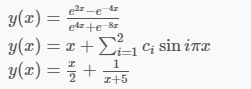

In [3]:
def f1(x):
    return (np.exp(2 * x) - np.exp(-4 * x)) / (np.exp(4 * x) + np.exp(-8 * x))

def f2(x):
    return x + sum(c * np.sin(i * np.pi * x) for i, c in enumerate([1, 0.5], 1))

def f3(x):
    return x**2 + 1 / (x + 5)

###Визуализируем

In [4]:
#визуализация с помощью plotly
def vis_data_plotly(y, y_true,x, title):
    fig = go.Figure()
    # рисуем с помощью библиотеки plotly
    fig.add_trace(
        go.Scatter(
        x=x[:,0],
        y=y_true[:,0],
        mode='lines+markers',
        name='Реальные данные',
        marker=dict(size = 10,
                    color='Green')
        )
    )
    fig.add_trace(
        go.Scatter(
        x=x[:,0],
        y=y[:,0],
        mode='markers',
        name='Зашумленные данные',
        opacity=0.5,
        marker=dict(size = 15,
                    color='LightSkyBlue',
                    line=dict(
                        color='Blue',
                        width=3
            )),

        )
    )
    fig.update_layout(
            title=title,
            width=1200,
            height=600,
        template = "plotly_dark"
            )

    fig.show()

In [5]:
#визуализация функции f1
y1, y1_true, x1 = dataset(f1,  N = 100,
                       x_max =1,
                       noise_power = 0.1,
                       seed = 42)
vis_data_plotly(y1, y1_true,x1, 'Гиперболическая зависимость')

In [6]:
#визуализация функции f2
y2, y2_true, x2 = dataset(f2,  N = 100,
                       x_max =1,
                       noise_power = 0.1,
                       seed = 42)
vis_data_plotly(y2, y2_true,x2, 'Синусоидальная зависимость')

In [7]:
#визуализация функции f3
y3, y3_true, x3 = dataset(f3,  N = 100,
                       x_max =1,
                       noise_power = 0.1,
                       seed = 42)
vis_data_plotly(y3, y3_true,x3, 'Квадратичная зависимость')

# Обучение модели линейной регрессии

###Тренировочная и тестовая выборки

In [8]:
#Разбиение данных на тренировочную-валидационную-тестовую
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state) # фиксируем случайный seed

    size = y.shape[0] # считаем сколько у нас точек
    idxs = np.arange(size) # массив индексов от 0 до количества точек
    if shuffle: np.random.shuffle(idxs) # если перемешиваем - то перемешиваем

    # если задаем test_size, но не задаем train_size
    if test_size and train_size is None:
        # тогда нам надо посчитать train_size
        # если размер задали в долях
        if (test_size<= 1):  train_size = 1 - test_size
        # если размер задали в штуках
        else:  train_size = size - test_size
        test_size = None    # обнулим переменную, чтобы потом не сломалось


    # если задаем train_size, но не задаем test_size, или мы некорректно задали размер  train_size
    if train_size is None or train_size > size: train_size = size

    # если задаем train_size
    if (train_size<= 1): train_size *= size

    # если test_size не обнулилось
    if test_size is not None:
        # если размер задали в долях
        if test_size<= 1: test_size *= size
        # если размер задали в штуках
        if test_size>size: test_size = size-train_size
    else: test_size = 0 # если обнулилось - то обнулилось)

    # разбиваем выборку на тренировочную и валидационную.
    # в тренировочную берем индексы от 0 до train_size
    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    # в валидационную берем индексы от train_size до size - test_size
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]

    # если test_size всё еще не обнулилось
    if test_size > 0:
        # в тестовую берем индексы от size - test_size до конца
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        # возвращаем тренировочную, валидационную и тестовую часть (сначала признаки, потом целевые метки)
        return x_train,  x_val, x_test, y_train.squeeze(), y_val.squeeze(), y_test.squeeze()
    # возвращаем тренировочную и валидационную  (сначала признаки, потом целевые метки)
    return x_train, x_val, y_train.squeeze(), y_val.squeeze()

In [9]:
#отрисовка тестовых и тренировочных данных
def plot_train_test_data(x_train, y_train, x_test, y_test,):
    fig = go.Figure()
    # рисуем с помощью библиотеки plotly
    fig.add_trace(
        go.Scatter(
        x=x_train[:,0],
        y=y_train,
        mode='markers',
        name='Тренировочные данные',
        marker=dict(size = 10,
                    color='Green')
        )
    )
    fig.add_trace(
        go.Scatter(
        x=x_test[:,0],
        y=y_test,
        mode='markers',
        name='Тестовые данные',
        marker=dict(size = 15,
                    color='LightSkyBlue',
                    line=dict(
                        color='Red',
                        width=3
            )),

        )
    )
    fig.update_layout(
            title='Тренировочные и тестовые данные для функции',
            width=1200,
            height=600,
        template = "plotly_dark"
            )

    fig.show()

**Визуализация тестовых данных для функции f1**

In [10]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1,  test_size=0.3, shuffle = True)
print(x1_train.shape, y1_train.shape,  x1_test.shape, y1_test.shape )

(70, 1) (70,) (30, 1) (30,)


In [11]:
plot_train_test_data(x1_train, y1_train, x1_test, y1_test)

**Визуализация тестовых данных для функции f2**

In [12]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2,  test_size=0.3, shuffle = True)
print(x2_train.shape, y2_train.shape,  x2_test.shape, y2_test.shape )

(70, 1) (70,) (30, 1) (30,)


In [13]:
plot_train_test_data(x2_train, y2_train, x2_test, y2_test)

**Визуализация тестовых данных для функции f3**

In [14]:
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3,  test_size=0.3, shuffle = True)
print(x3_train.shape, y3_train.shape,  x3_test.shape, y3_test.shape )

(70, 1) (70,) (30, 1) (30,)


In [15]:
plot_train_test_data(x3_train, y3_train, x3_test, y3_test)

###Линейная регрессия

In [16]:
class LinearRegression():
    def __init__(self,
                 learning_rate = 0.5,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        self.n_batches = n_batches


    #---------------------------------
    def forward(self, X):
        # умножаем признаки на веса
        return np.dot(X, self.weights)

    #---------------------------------
    def loss(self,yhat, y):
        # расчет функции потерь
        return np.square(yhat - y).sum()/y.size

    #---------------------------------
    def grad_step(self,yhat, y, X):
        # расчет градиента
        return 2*np.dot(X.T, (yhat - y)) / y.size

    #---------------------------------
    def update(self):
        # обновление весов
        return self.weights - self.lr*self.grad

    #---------------------------------
    def init(self, weights_size):
        # инициализируем веса
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)

    #---------------------------------
    def predict(self, X):
        # делем предсказание модели
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()

    #---------------------------------
    def score(self, X, y):
        # оценка по коэффициенту детерминации
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

    #---------------------------------
    def fit(self, X, y):
        # обучение модели с учетом разбиения на батчи
        np.random.seed(self.seed)

        if self.weights is None: # если веса не заданы - задаем
            self.weights = self.init(X.shape[1])

        if self.bias is None: # если смещение не задано - задаем
            self.bias    = self.init(1)

        if self.weights.size == X.shape[1]: # если веса заданы, но не добавлено смещение - объединяем
            self.weights = np.append(self.bias,self.weights)

        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:   # проверка на согласование размерности батча и размерности данных
            self.batch_size = y.size

        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size

        for i in range(self.epochs): #циклы обучения, как раньше
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)):

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch)
                self.weights = self.update()
                loss += self.loss(yhat,  y_batch)

                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches

        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        # загрузка батча
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch) # тут мы всегда добавляем смещение
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch

    #---------------------------------
    def add_bias(self, X):
        # добавление смещения
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = 'Кривая обучения'):
        # отрисовка сразу в методе
        fig = go.Figure()
            # рисуем с помощью библиотеки plotly
        fig.add_trace(
                go.Scatter(
                y=self.cost,
                mode='lines+markers',
                name='Реальные данные',

                )
            )
        fig.update_layout(
                    title=title,
                    width=1200,
                    height=600,
                template = "plotly_dark"
                    )

        fig.show()

    #---------------------------------
    def get_w_and_b(self):
        # "новый" метод - который возвращает веса модели и смещение
        return (self.weights[1:], self.bias)

**Нарисуем кривую обучения для функции f1**

In [17]:
# Создаем экземпляр класса
lin_reg_1 = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)
# Применяем метод fit
lin_reg_1.fit(x1_train, y1_train)

print(f'Коэффициент детерминации на тренировочных данных = {lin_reg_1.score(x1_train, y1_train):.2f}')
lin_reg_1.plot_cost()

Коэффициент детерминации на тренировочных данных = -0.09


**Нарисуем кривую обучения для функции f2**

In [18]:
# Создаем экземпляр класса
lin_reg_2 = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)
# Применяем метод fit
lin_reg_2.fit(x2_train, y2_train)

print(f'Коэффициент детерминации на тренировочных данных = {lin_reg_2.score(x2_train, y2_train):.2f}')
lin_reg_2.plot_cost()

Коэффициент детерминации на тренировочных данных = 0.03


**Нарисуем кривую обучения для функции f3**

In [19]:
# Создаем экземпляр класса
lin_reg_3 = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)
# Применяем метод fit
lin_reg_3.fit(x3_train, y3_train)

print(f'Коэффициент детерминации на тренировочных данных = {lin_reg_3.score(x3_train, y3_train):.2f}')
lin_reg_3.plot_cost()

Коэффициент детерминации на тренировочных данных = 0.82


In [20]:
#Отрисовка модели
def plot_model_class(x_train, y_train, x_test, x, y, model):
    fig = go.Figure()
    # рисуем с помощью библиотеки plotly
    fig.add_trace(
        go.Scatter(
        x=x_test[:,0],
        y=model.predict(x_test, ),
        mode='markers',
        name='Предсказание на x_test',
        marker=dict(size = 5,
                    color='Blue')
        )
    )
    fig.add_trace(
        go.Scatter(
        x=x_train[:,0],
        y=model.predict(x_train, ),
        mode='markers',
        name='Предсказание на x_train',
        marker=dict(size = 10,
                    color='LightSkyBlue',
                    ),

        )
    )

    fig.add_trace(
        go.Scatter(
        x=x_train[:,0],
        y=y_train,
        mode='markers',
        name='Тренировочные данные',
        marker=dict(size = 5,
                    color='Red')
        )
    )

    fig.add_trace(
        go.Scatter(
        x=x[:,0],
        y=y[:,0],
        mode='lines+markers',
        name='Истинные значения',
        opacity = 0.7,
        marker=dict(size = 10,
                    color='green',),

        )
    )

    fig.update_layout(
            title='Предсказание модели',
            width=1200,
            height=600,
        template = "plotly_dark"
            )

    fig.show()

**Отрисовка модели для функции f1**

In [21]:
plot_model_class(x1_train, y1_train, x1_test, x1, y1_true, lin_reg_1);

**Отрисовка модели для функции f2**

In [22]:
plot_model_class(x2_train, y2_train, x2_test, x2, y2_true, lin_reg_2);

**Отрисовка модели для функции f3**

In [23]:
plot_model_class(x3_train, y3_train, x3_test, x3, y3_true, lin_reg_3);

Полный провал, а не предсказание.

#Полиномиальные данные

In [24]:
#генерация полиномиальных признаков
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))# складываем в выходную переменную все степени от 0/1 до order
    return out.reshape(-1, x.size).T

In [25]:
#сделаем полиномы до 3й степени для f1
x1_ = to_polynom(x1, order = 3)
x1_train, x1_test, y1_train, y1_test = train_test_split(x1_, y1,  test_size=0.3, )

#создадим новую модель
regr_poly_1 = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

#обучим ее методом fit
regr_poly_1.fit(x1_train, y1_train)

print(f'Коэффициент детерминации на тренировочных данных = {regr_poly_1.score(x1_train, y1_train):.2f}')
regr_poly_1.plot_cost()

plot_model_class(x1_train, y1_train, x1_test, x1, y1_true, regr_poly_1);

Коэффициент детерминации на тренировочных данных = 0.30


In [26]:
#сделаем полиномы до 3й степени для f2
x2_ = to_polynom(x2, order = 3)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2_, y2,  test_size=0.3, )

#создадим новую модель
regr_poly_2 = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

#обучим ее методом fit
regr_poly_2.fit(x2_train, y2_train)

print(f'Коэффициент детерминации на тренировочных данных = {regr_poly_2.score(x2_train, y2_train):.2f}')
regr_poly_2.plot_cost()

plot_model_class(x2_train, y2_train, x2_test, x2, y2_true, regr_poly_2);

Коэффициент детерминации на тренировочных данных = 0.48


как то не очень


In [27]:
#сделаем полиномы до 3й степени для f3
x3_ = to_polynom(x3, order = 3)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3_, y3,  test_size=0.3, )

#создадим новую модель
regr_poly_3 = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

#обучим ее методом fit
regr_poly_3.fit(x3_train, y3_train)

print(f'Коэффициент детерминации на тренировочных данных = {regr_poly_3.score(x3_train, y3_train):.2f}')
regr_poly_3.plot_cost()

plot_model_class(x3_train, y3_train, x3_test, x3, y3_true, regr_poly_3);

Коэффициент детерминации на тренировочных данных = 0.92


О, уже лучше. Посмотрим на веса для функции f3


In [28]:
#отрисовка весов
def vis_weigths(weights):
    numbers = np.arange(0,len(weights)) # создаем массив от 0 до количество весов-1
    tick_labels = np.array(['w'+str(num) for num in numbers]) # создаем "названия" весов


    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=1200,
                height=600,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels,
                                         )
                )

    fig.show()

In [29]:
w, b = regr_poly_3.get_w_and_b()
print(w,b)
vis_weigths(np.hstack([b,w]))

[0.38614674 0.12574669 0.56417161] 0.1359752756887249


Все веса вносят положительный вклад. Больше всего вносит вес w3

#Полиномиальная регрессия

Создадим наш набор данных из 10 степеней полиномов


In [30]:
order  = 10

#для функции f1
x1_train_ = to_polynom(x1_train, order=order) # для тренировочных
x1_test_  = to_polynom(x1_test,  order=order) # для тестовых


pd.DataFrame(x1_train_).tail(4)

,0,1,2,3,4,5,6,7,8,9
206,0.213740,0.045685,0.009765,0.002087,0.000446,0.000095,0.000020,0.000004,9.310447e-07,1.990014e-07
207,0.969585,0.940094,0.911501,0.883777,0.856897,0.830834,0.805564,0.781062,7.573062e-01,7.342724e-01
208,0.940094,0.883777,0.830834,0.781062,0.734272,0.690285,0.648933,0.610059,5.735126e-01,5.391560e-01
209,0.911501,0.830834,0.757306,0.690285,0.629196,0.573513,0.522757,0.476494,4.343246e-01,3.958874e-01


In [31]:
regr_harm_poly_1 = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_1.fit(x1_train_, y1_train)

regr_harm_poly_1.plot_cost()

vis_weigths(np.hstack([b,w]))

plot_model_class(x1_train_, y1_train, x1_test_, x1, y1_true, regr_harm_poly_1);

In [32]:
#для функции f1
x2_train_ = to_polynom(x2_train, order=order) # для тренировочных
x2_test_  = to_polynom(x2_test,  order=order) # для тестовых


pd.DataFrame(x2_train_).tail(4)

regr_harm_poly_2 = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_2.fit(x2_train_, y2_train)

regr_harm_poly_2.plot_cost()

vis_weigths(np.hstack([b,w]))

plot_model_class(x2_train_, y2_train, x2_test_, x2, y2_true, regr_harm_poly_2);

опять не то, да что такое

#Перемаштабирование-нормализация

In [33]:
class MinMaxScaler:
    # Класс нормализации. Класс чтобы "запомнить" параметры которые вычитали / делили
    def __init__(self):
        self.min = 0
        self.max = 0
    def fit(self,X):
        # обучаем - ищем максимальное и минимальное значение
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        return self
    def transform(self,X):
        # трансформируем по формуле
        return (X- self.min)/(self.max-self.min)
    def fit_transform(self,X):
        # питоновское "объединяем" два метода в один
        return self.fit(X).transform(X)

In [34]:
class StandardScaler:
    # Класс стандартизации. Класс чтобы "запомнить" параметры которые вычитали / делили
    def __init__(self):
        self.mean = 0
        self.std = 1
    def fit(self,X):
        # обучаем - ищем среднее и стандартное отклонение
        self.mean = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self,X):
        # трансформируем по формуле
        return (X- self.mean)/(self.std)
    def fit_transform(self,X):
        # питоновское "объединяем" два метода в один
        return self.fit(X).transform(X)

Теперь воспользуемся **стандартизацией**

In [35]:
scaler = StandardScaler() # создаем экземпляр класса

#для функции f1
x1_train_scaled = scaler.fit_transform(x1_train_) # обучаем на тренировочных и сразу трансформируем
x1_test_scaled = scaler.transform(x1_test_) # обучаем трансформируем тестовые данные

pd.DataFrame(x1_test_scaled).tail(4)

,0,1,2,3,4,5,6,7,8,9
86,1.569522,1.605132,1.461355,1.260175,1.050102,0.851958,0.674197,0.519328,0.386963,0.275363
87,0.610390,0.213844,-0.060457,-0.214838,-0.291674,-0.324332,-0.333601,-0.331292,-0.323756,-0.314256
88,-0.217288,-0.479521,-0.507551,-0.474790,-0.435520,-0.401864,-0.374763,-0.352940,-0.335069,-0.320142
89,-0.625992,-0.648587,-0.561383,-0.490245,-0.439743,-0.402988,-0.375057,-0.353016,-0.335089,-0.320147


In [36]:
regr_harm_poly_scale_1 = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale_1.fit(x1_train_scaled, y1_train)

regr_harm_poly_scale_1.plot_cost()

w, b = regr_harm_poly_scale_1.get_w_and_b()

vis_weigths(np.hstack([b,w]))

fig = go.Figure()
    # рисуем с помощью библиотеки plotly
fig.add_trace(
    go.Scatter(
    x=x1_test[:,0],
    y=regr_harm_poly_scale_1.predict(x1_test_scaled),
    mode='markers',
    name='Предсказание на x_test',
    marker=dict(size = 5,
                color='Blue')
    )
)
fig.add_trace(
    go.Scatter(
    x=x1_train[:,0],
    y=regr_harm_poly_scale_1.predict(x1_train_scaled),
    mode='markers',
    name='Предсказание на x_train',
    marker=dict(size = 10,
                color='LightSkyBlue',
                ),

    )
)

fig.add_trace(
    go.Scatter(
    x=x1_train[:,0],
    y=y1_train,
    mode='markers',
    name='Тренировочные данные',
    marker=dict(size = 5,
                color='Red')
    )
)

fig.add_trace(
    go.Scatter(
    x=x1[:,0],
    y=y1_true[:,0],
    mode='lines+markers',
    name='Истинные значения',
    opacity = 0.7,
    marker=dict(size = 10,
                color='green',),

    )
)

# возьмем дополнительную точку "вне" тренировочного диапазона
x_new = np.array([1.05, 1.07, 1.08, 1.09, 1.1])
fig.add_trace(
    go.Scatter(
    x=x_new,
    y=regr_harm_poly_scale_1.predict(scaler.transform(to_polynom(x_new, order=order))),
    mode='markers',
    name='Новые данные',
    marker=dict(size = 5,
                color='Purple')
    )
)

fig.update_layout(
        title='Предсказание модели',
        width=1200,
        height=600,
    template = "plotly_dark"
        )

fig.show()

In [37]:
#для функции f2
x2_train_scaled = scaler.fit_transform(x2_train_) # обучаем на тренировочных и сразу трансформируем
x2_test_scaled = scaler.transform(x2_test_) # обучаем трансформируем тестовые данные

pd.DataFrame(x2_test_scaled).tail(4)

regr_harm_poly_scale_2 = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale_2.fit(x2_train_scaled, y2_train)

regr_harm_poly_scale_2.plot_cost()

w, b = regr_harm_poly_scale_2.get_w_and_b()

vis_weigths(np.hstack([b,w]))

fig = go.Figure()
    # рисуем с помощью библиотеки plotly
fig.add_trace(
    go.Scatter(
    x=x2_test[:,0],
    y=regr_harm_poly_scale_2.predict(x2_test_scaled),
    mode='markers',
    name='Предсказание на x_test',
    marker=dict(size = 5,
                color='Blue')
    )
)
fig.add_trace(
    go.Scatter(
    x=x2_train[:,0],
    y=regr_harm_poly_scale_2.predict(x2_train_scaled),
    mode='markers',
    name='Предсказание на x_train',
    marker=dict(size = 10,
                color='LightSkyBlue',
                ),

    )
)

fig.add_trace(
    go.Scatter(
    x=x2_train[:,0],
    y=y2_train,
    mode='markers',
    name='Тренировочные данные',
    marker=dict(size = 5,
                color='Red')
    )
)

fig.add_trace(
    go.Scatter(
    x=x2[:,0],
    y=y2_true[:,0],
    mode='lines+markers',
    name='Истинные значения',
    opacity = 0.7,
    marker=dict(size = 10,
                color='green',),

    )
)

# возьмем дополнительную точку "вне" тренировочного диапазона
x_new = np.array([1.05, 1.07, 1.08, 1.09, 1.1])
fig.add_trace(
    go.Scatter(
    x=x_new,
    y=regr_harm_poly_scale_2.predict(scaler.transform(to_polynom(x_new, order=order))),
    mode='markers',
    name='Новые данные',
    marker=dict(size = 5,
                color='Purple')
    )
)

fig.update_layout(
        title='Предсказание модели',
        width=1200,
        height=600,
    template = "plotly_dark"
        )

fig.show()

Мини вывод - стандартизация данных может улучшить результаты. Но не в этих случаях

#Регуляризация

###Регуляризация Тихонова

In [38]:
class RidgeRegression(LinearRegression): #унаследуем всё что можно от "базовой" модели
    def __init__(self,
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty

    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):
        # изменяем правило обновление весов
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)

In [39]:
#для функции f1
regr_l2_1 = RidgeRegression(learning_rate=0.25,
                       epochs=300, batch_size=10,
                       l2_penalty = 0.001)
regr_l2_1.fit(x1_train_, y1_train)

regr_l2_1.plot_cost()

w, b = regr_l2_1.get_w_and_b()

vis_weigths(np.hstack([b,w]))

plot_model_class(x1_train_, y1_train, x1_test_, x1, y1_true, regr_l2_1);

А куда исчезли тренировочные данные ???

In [40]:
#для функции f1
regr_l2_2 = RidgeRegression(learning_rate=0.25,
                       epochs=300, batch_size=10,
                       l2_penalty = 0.001)
regr_l2_2.fit(x2_train_, y2_train)

regr_l2_2.plot_cost()

w, b = regr_l2_2.get_w_and_b()

vis_weigths(np.hstack([b,w]))

plot_model_class(x2_train_, y2_train, x2_test_, x2, y2_true, regr_l2_2);

Это что вообще💀💀💀

###Регуляризация L1

In [41]:
class LassoRegression(LinearRegression): #унаследуем всё что можно от "базовой" модели
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty

    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term

    #---------------------------------
    def update(self):
        # изменяем правило обновление весов
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)

In [42]:
#для функции f1
regr_l1_1 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=10,
                       l1_penalty = 0.001)
regr_l1_1.fit(x1_train_, y1_train)

regr_l1_1.plot_cost()

w, b = regr_l1_1.get_w_and_b()

vis_weigths(np.hstack([b,w]))

plot_model_class(x1_train_, y1_train, x1_test_, x1, y1_true, regr_l1_1);

In [43]:
#для функции f2
regr_l1_2 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=10,
                       l1_penalty = 0.001)
regr_l1_2.fit(x2_train_, y2_train)

regr_l1_2.plot_cost()

w, b = regr_l1_2.get_w_and_b()

vis_weigths(np.hstack([b,w]))

plot_model_class(x2_train_, y2_train, x2_test_, x2, y2_true, regr_l1_2);

Шла третья(или четвертая) попытка привести это в порядок...не удается

###Эластичная регуляризация

In [44]:
class ElasticRegression(LinearRegression): #унаследуем всё что можно от "базовой" модели
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term

    #---------------------------------
    def update(self):
        # изменяем правило обновление весов
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

In [45]:
#для функции f1
regr_l1l2_1 = ElasticRegression(learning_rate=0.1,
                         epochs=300,batch_size=10,
                         l1_penalty = 0.0001,l2_penalty = 0.001 )
regr_l1l2_1.fit(x1_train_, y1_train)

regr_l1l2_1.plot_cost()

w, b = regr_l1l2_1.get_w_and_b()

vis_weigths(np.hstack([b,w]))

plot_model_class(x1_train_, y1_train, x1_test_, x1, y1_true, regr_l1l2_1);

In [46]:
#Для функции f2
regr_l1l2_2 = ElasticRegression(learning_rate=0.1,
                         epochs=300,batch_size=10,
                         l1_penalty = 0.0001,l2_penalty = 0.001 )
regr_l1l2_2.fit(x2_train_, y2_train)

regr_l1l2_2.plot_cost()

w, b = regr_l1l2_2.get_w_and_b()

vis_weigths(np.hstack([b,w]))

plot_model_class(x2_train_, y2_train, x2_test_, x2, y2_true, regr_l1l2_2);

#Артефакты

Давайте сделаем артефакты хотя бы для функции f3. Продублируем веса и визуализацию и добавим метрики.

In [47]:
#сделаем полиномы до 3й степени для f3
x3_ = to_polynom(x3, order = 3)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3_, y3,  test_size=0.3, )

#создадим новую модель
regr_poly_3 = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

#обучим ее методом fit
regr_poly_3.fit(x3_train, y3_train)

print(f'Коэффициент детерминации на тренировочных данных = {regr_poly_3.score(x3_train, y3_train):.2f}')
regr_poly_3.plot_cost()

plot_model_class(x3_train, y3_train, x3_test, x3, y3_true, regr_poly_3);

w, b = regr_poly_3.get_w_and_b()
print(w,b)
vis_weigths(np.hstack([b,w]))

# Делаем предсказания на тестовой выборке
y3_test_pred = regr_poly_3.predict(x3_test)

# Вычисляем метрики на тестовой выборке
mse_test = mean_squared_error(y3_test, y3_test_pred)
r2_test = r2_score(y3_test, y3_test_pred)

print(f"MSE на тестовой выборке = {mse_test:.2f}")
print(f"R² на тестовой выборке = {r2_test:.2f}")

Коэффициент детерминации на тренировочных данных = 0.92


[0.38614674 0.12574669 0.56417161] 0.1359752756887249


MSE на тестовой выборке = 0.01
R² на тестовой выборке = 0.90


# Выводы

Первые две функции (синусоидальная и гиперболическая) никак не удалось привести к нормальному предсказанию. Либо дело в неумелом пользовании методами стандартизации и регуляризации, либо где-то было напутано в переменных или данных. Однако получилось построить хорошую модель для квадратичной зависимостии. Это видно и по графикам и по метрикам.